# Make trees and batches of trees.

In [1]:
import msprime
from IPython.display import SVG, display
import networkx as nx
import jax
import jax.numpy as nmp
from jax.nn import log_softmax
import equinox as eqx
import itertools as it
import optax
import tskit
import numpy as np
from collections import defaultdict

In [2]:
num_ts = 100

In [3]:
ts = msprime.sim_ancestry(
        samples=4,
        recombination_rate=1e-8,
        sequence_length=20_000,
        population_size=8_000)
mts = msprime.sim_mutations(ts, rate = 1e-8)
sparse_genotype = mts.genotype_matrix().T
breakpoints = list(mts.breakpoints())
mutation_sites = [site.position for site in mts.sites()]

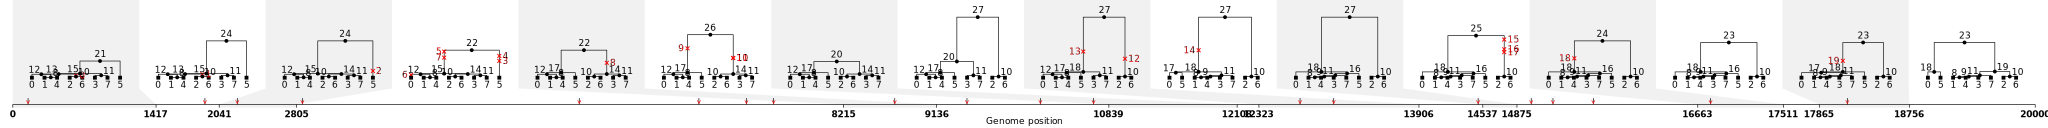

In [26]:
SVG(mts.draw_svg())

In [27]:
dods = [tree.as_dict_of_dicts() for tree in ts.trees()]
tree_graphs = [nx.Graph(dod) for dod in dods]
edge_pairs = [list(tree_graph.edges) for tree_graph in tree_graphs]
edge_pairs_backwards = [[(b, a) for (a, b) in sublist] for sublist in edge_pairs]
senders = [np.array([a for (a, b) in sublist]) for sublist in edge_pairs_backwards]
receivers = [np.array([b for (a, b) in sublist]) for sublist in edge_pairs_backwards]


In [ ]:
def diff_spr(t1, t2):
    assert t1.num_samples() == t2.num_samples()
    nodes = set(range(t1.num_samples()))
    while nodes:
        x = nodes.pop()
        p1, p2 = [t.get_parent(x) for t in [t1, t2]]
        if p1 != p2:
            return x
        if p1 != -1:
            nodes.add(p1)
            
def find_spr(t1, t2):
    start0 = diff_spr(t1, t2)
    deleted = t1.parent(start0)
    start1, = t1.siblings(start0)
    # the recombination could have occured either on (start0, deleted) or (start1, deleted)
    # to settle this, in t2, one of them will have the same grandparent and the other wont
    gp = t1.parent(deleted)
    gp0 = t2.parent(start0)
    gp1 = t2.parent(start1)
    start = start1 if gp0 == gp else start0
    end, = t2.siblings(start)
    if t1.parent(end) == tskit.NULL:
        x = t2.time(t2.parent(end)) - t2.time(end)
        root = True
    else:
        t0 = t1.time(t1.parent(end)) - t1.time(end)
        t1 = t2.time(t2.parent(end)) - t2.time(end)
        x = t1 / t0
        root = False
    return (start, deleted)

for t1, t2 in it.pairwise(ts.aslist()):
  find_spr(t1, t2)

(5, 21)
(10, 13)
(5, 24)
(5, 22)
(14, 22)
(14, 26)
(10, 14)
(11, 20)
(8, 12)
(5, 17)
(10, 27)
(10, 25)
(10, 24)
(0, 18)
(11, 17)
